<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/COVID_MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis estadístico del dataset de COVID-19 proporcionado por la secretaría de salud.

### Objetivos
* Identidicar los factores de los pacientes que aumentan su probabilidad de fallecer o presentar enfermedad grave.
* Identificar si la mortalidad varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si la probabilidad de padecer la enfermedad grave varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si los dias entre el inicio de los sintomas y la atención médica afecta en la mortalidad.
* Conocer si la mortalidad y la positividad cambió en el transcurso de la pandemia.
* Realizar una limpieza y tratamiento de datos para obtener un dataset listo para crear un modelo predictorio de la probabilidad de muerte de un paciente dadas sus características.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import os
import sys
import seaborn as sns

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from sklearn import linear_model

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Librería hecha para manejar el dataset de covid
#sys.path.insert(1,'/content/drive/MyDrive/Python Scripts/')
sys.path.insert(1,'../Proyecto en Twitter/')
import COVID19_MX as covid

## Carga de Dataset principal y auxiliares
Los dataset auxiliares `sexo_df`, `sector_df` y `entidad_df` servirán para usar variables categóricas en el modelo.

In [4]:
#aux_dataset_path = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Diccionario%20de%20Datos"
#main_dataset_path = "/content/drive/MyDrive/Datos Abiertos"

aux_dataset_path = "C:/Users/alana/Documentos/GitHub/COVIDSTATSMX/Diccionario de Datos"
main_dataset_path = "C:/Users/alana/Documentos/COVIDSTATSMX/Datos Abiertos"
covid_file = "220129COVID19MEXICO.csv"
sexo_file = "Sexo.csv"
sector_file = "Sector.csv"
entidad_file = "Entidad.csv"

In [5]:
covid_df = pd.read_csv(os.path.join(main_dataset_path,covid_file))
sexo_df = pd.read_csv(os.path.join(aux_dataset_path,sexo_file))
sector_df = pd.read_csv(os.path.join(aux_dataset_path,sector_file))
entidad_df = pd.read_csv(os.path.join(aux_dataset_path,entidad_file))

## Limpieza y Tratamiento de Datos

In [6]:
covid_df.sample(2)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
3639974,2022-01-29,394570,2,12,17,1,17,17,18,1,...,1,2,97,1,2,7,99,México,97,97
3254398,2022-01-29,2fe331,2,12,9,2,15,9,6,1,...,1,2,97,1,1,3,99,México,97,97


In [7]:
covid_df.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CASO                 int64
TOMA_MUE

In [8]:
covid_df.shape

(14049746, 40)

In [9]:
list(covid_df.columns)

['FECHA_ACTUALIZACION',
 'ID_REGISTRO',
 'ORIGEN',
 'SECTOR',
 'ENTIDAD_UM',
 'SEXO',
 'ENTIDAD_NAC',
 'ENTIDAD_RES',
 'MUNICIPIO_RES',
 'TIPO_PACIENTE',
 'FECHA_INGRESO',
 'FECHA_SINTOMAS',
 'FECHA_DEF',
 'INTUBADO',
 'NEUMONIA',
 'EDAD',
 'NACIONALIDAD',
 'EMBARAZO',
 'HABLA_LENGUA_INDIG',
 'INDIGENA',
 'DIABETES',
 'EPOC',
 'ASMA',
 'INMUSUPR',
 'HIPERTENSION',
 'OTRA_COM',
 'CARDIOVASCULAR',
 'OBESIDAD',
 'RENAL_CRONICA',
 'TABAQUISMO',
 'OTRO_CASO',
 'TOMA_MUESTRA_LAB',
 'RESULTADO_LAB',
 'TOMA_MUESTRA_ANTIGENO',
 'RESULTADO_ANTIGENO',
 'CLASIFICACION_FINAL',
 'MIGRANTE',
 'PAIS_NACIONALIDAD',
 'PAIS_ORIGEN',
 'UCI']

### Se agrega columna Resultado
**Se agrega la columna de `RESULTADO` para facilitar el análisis** 
* Positivo: 1
* Negativo: 2
* Sospechoso: 3

In [10]:
covid_df["RESULTADO"] = covid_df["CLASIFICACION_FINAL"].apply(covid.getResult)

In [11]:
covid_df[["CLASIFICACION_FINAL","RESULTADO"]].sample(10)

,CLASIFICACION_FINAL,RESULTADO
9149762,3,1
1512470,3,1
457280,3,1
13788669,7,2
6965866,7,2
12712923,7,2
1866269,6,3
844478,7,2
12656172,1,1
1723206,7,2


In [12]:
date = "2022-01-29"
comulative_cases = covid.getComulativeCases(covid_df)
covid.printCumulativeCases(comulative_cases, date)

Fecha de actualización: 2022-01-29

  Total de casos estudiados: 14049746

  Casos Positivos a SARS-CoV-2: 4916143

  Casos No Positivos a SARS-CoV-2: 8495304

  Casos Con Resultado Pendiente: 638299

  Defunciones Positivas a SARS-CoV-2: 305762

  Tasa de Letalidad: 6.220%

  Tasa de Positividad : 36.656%



### Filtrado de casos con datos incompletos

En el diccionario de datos se identifico que hay valores *no aplica* o *no especificado*, para realizar el análisis hay que eliminar esos valores, ya sea eliminando el caso que los contenga o cambiandolo. El problema es que esos valores están en varias columnas, por lo tanto se tendrá que usar un `for loop`.

In [13]:
# Se filtra el dataset para eliminar casos con información No especificada y se toman solamente los casos positivos.
data_filtered = covid_df[(covid_df["SEXO"] != 99)
& (covid_df["SECTOR"] != 99)
& (covid_df["ENTIDAD_UM"] < 97)
& (covid_df["RESULTADO"] == 1)]

In [14]:
# Se filtran los datos No especificados de las categorias SI-NO (leer el diccionario de datos)
data_filtered["EMBARAZO"] = np.where(data_filtered["SEXO"] == 2, 2, data_filtered["EMBARAZO"])

categorias_si_no = ['INTUBADO','UCI','NEUMONIA','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                    'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO','EMBARAZO']

for cat in categorias_si_no:
  data_filtered = data_filtered[data_filtered[cat] <= 97]
  data_filtered[cat] = data_filtered[cat].apply(lambda x: 1 if x == 1 else 0)

In [15]:
# Se eliminan los datos no especificados de la columna TIPO_PACIENTE
data_filtered = data_filtered[data_filtered["TIPO_PACIENTE"] != 99]

In [16]:
data_filtered.shape

(4854819, 41)

Oficialmente hay 2,244,268 casos positivos a SARS-COV-2, pero después del filtrado obtuvimos 2,221,525, hay una diferencia de 22,743 casos, esto se debe a que se eliminaron casos con información incompleta. Por la cantidad de datos esta diferencia es estadísticamente insignificante y no supondrá un problema en el análisis o en la creación del modelo.

In [17]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO
13521691,2022-01-29,c291a2,2,4,16,1,16,16,53,1,...,2,97,1,1,3,99,México,97,0,1
8980858,2022-01-29,7f5bf3,2,12,23,2,23,23,10,1,...,2,97,1,1,3,99,México,97,0,1
9473410,2022-01-29,9ca001,2,4,21,2,21,21,114,1,...,2,97,1,1,3,99,México,97,0,1
2422732,2022-01-29,3e97b2,2,12,20,1,20,20,67,1,...,1,1,2,97,3,99,México,97,0,1
1017803,2022-01-29,02edf7,1,12,31,2,31,31,50,1,...,1,1,2,97,3,99,México,97,0,1


### Cambio de tipo de dato de fechas
**Las columnas de `FECHA_SINTOMAS` y `FECHA_INGRESO` correspondientes a la fecha de inicio de sintomas y a la fecha de ingreso a la unidad de atención estan en string, se les cambiará a tipo de dato `datetima` para el manejo de fechas**

In [18]:
data_filtered["FECHA_INGRESO"] = pd.to_datetime(data_filtered["FECHA_INGRESO"], format = "%Y-%m-%d")

In [19]:
data_filtered["FECHA_SINTOMAS"] = pd.to_datetime(data_filtered["FECHA_SINTOMAS"], format = "%Y-%m-%d")

In [20]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].dtypes

FECHA_INGRESO     datetime64[ns]
FECHA_SINTOMAS    datetime64[ns]
dtype: object

In [21]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].sample(5)

,FECHA_INGRESO,FECHA_SINTOMAS
2800103,2020-11-25,2020-11-21
1095922,2020-06-26,2020-06-23
12807691,2021-01-07,2021-01-04
12107592,2021-12-16,2021-12-06
8916088,2021-08-11,2021-08-09


### Agregado de columna `TIEMPO_ESPERA`
Se agrega la columna `TIEMPO_ESPERA` que indica el tiempo en días que paso desde el inicio de los sintomas `FECHA_SINTOMAS` y el ingreso a la unidad de salud `FECHA_INGRESO`.

In [22]:
data_filtered["TIEMPO_ESPERA"] = data_filtered["FECHA_INGRESO"] - data_filtered["FECHA_SINTOMAS"]
data_filtered["TIEMPO_ESPERA"] = data_filtered["TIEMPO_ESPERA"].apply(lambda x: x.days)

In [23]:
data_filtered["TIEMPO_ESPERA"].dtypes

dtype('int64')

### Agregado de columna `FALLECIDO`
Esta columna será catagórica, indica si el paciente falleció por covid, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [24]:
data_filtered["FALLECIDO"] = data_filtered["FECHA_DEF"].apply(lambda x: 1 if x != "9999-99-99" else 0)

In [25]:
data_filtered[["FECHA_DEF","FALLECIDO"]].sample(10)

,FECHA_DEF,FALLECIDO
336998,9999-99-99,0
7334037,9999-99-99,0
9473457,9999-99-99,0
11178821,9999-99-99,0
1086044,9999-99-99,0
1483241,9999-99-99,0
8358959,9999-99-99,0
1968246,9999-99-99,0
4586841,2021-02-12,1
8849725,9999-99-99,0


### Agregado de la columna `ENFERMEDAD_GRAVE`
Esta columna será catagórica, indica si el paciente presentó enfermedad grave.

Se considera que un paciente presentó la enfermedad grave si presenta al menos una de las siguientes situaciones:
* El paciente requirió de intubación.
* El paciente fue diagnosticado con neumonía.
* El paciente requirió ingresar a una Unidad de Cuidados Intensivos.

Los valores posibles en esta columna son los siguientes:
* Si: *1*
* No: *0*

In [26]:
data_filtered["ENFERMEDAD_GRAVE"] = np.where((data_filtered["INTUBADO"] == 1) 
| (data_filtered["NEUMONIA"] == 1)
| (data_filtered["UCI"] == 1) , 1, 0)

In [27]:
data_filtered[["NEUMONIA", "INTUBADO", "UCI", "ENFERMEDAD_GRAVE"]].sample(10)

,NEUMONIA,INTUBADO,UCI,ENFERMEDAD_GRAVE
11016698,0,0,0,0
2754359,0,0,0,0
1879773,0,0,0,0
4512015,0,0,0,0
8180379,0,0,0,0
803845,0,0,0,0
3671653,1,0,0,1
8863079,0,0,0,0
7428454,0,0,0,0
3523636,0,0,0,0


### Agregado de columna `HOSPITALIZADO`
Esta columna será catagórica, indica si el paciente fue hospitalizado, si esto no es así se asume que el tratamiento del paciente fue embulatorio, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [28]:
data_filtered["HOSPITALIZADO"] = data_filtered["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)

In [29]:
data_filtered[["TIPO_PACIENTE", "HOSPITALIZADO"]].sample(10)

,TIPO_PACIENTE,HOSPITALIZADO
140524,1,0
10122189,1,0
8215889,1,0
6700438,2,1
9248683,1,0
2257203,1,0
6863512,1,0
2455161,1,0
908256,1,0
8935865,1,0



### Combinación del dataframe principal con los dataframes auxiliares.

In [30]:
# Se le cambian los nombres de las columnas a los dataframes auxiliares
sexo_df.columns = ["SEXO", "SEXO_"]
sector_df.columns = ["SECTOR", "SECTOR_ATENDIDO"]
entidad_df.columns = ["ENTIDAD_UM","ESTADO"]

In [31]:
data_filtered = pd.merge(data_filtered, sexo_df, how = "inner", on = "SEXO")
data_filtered = pd.merge(data_filtered, sector_df, how = "inner", on = "SECTOR")
data_filtered = pd.merge(data_filtered, entidad_df, how = "inner", on = "ENTIDAD_UM")

In [32]:
data_filtered[["SEXO_","SECTOR_ATENDIDO","ESTADO"]].sample(5)

,SEXO_,SECTOR_ATENDIDO,ESTADO
2636192,HOMBRE,SSA,SP
3269070,MUJER,IMSS,GT
4672127,MUJER,SSA,DG
3996531,HOMBRE,SSA,MN
4780818,MUJER,SSA,MS


## Análisis Exploratorio

En esta sección se obtendrán algunos datos estadísticos que pueden ayudar a comprender el comportamiento de la enfermedad.

In [33]:
# Para esta sección se definio una función para obtener los cartiles
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

### Distribución de edad por sexo de los infectados.

Text(0, 0.5, 'Número de casos confirmados')

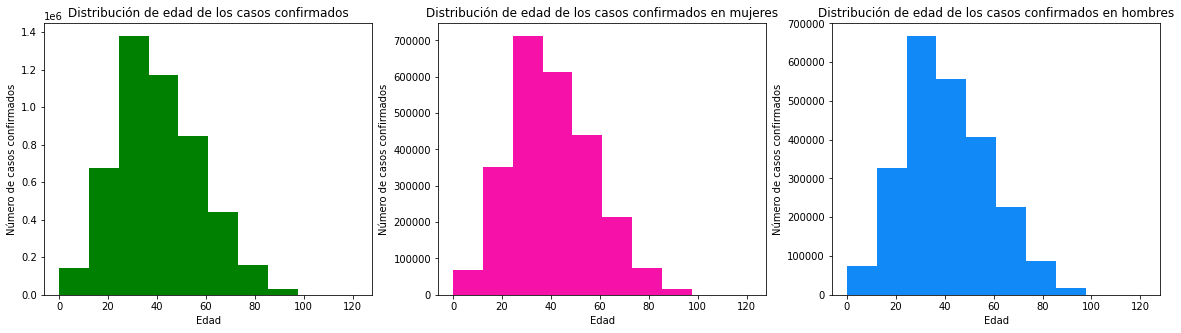

In [34]:
fig, axs = plt.subplots(ncols = 3, nrows = 1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"], color="g")
axs[0].set_title("Distribución de edad de los casos confirmados")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "MUJER"], color="#F611A9")
axs[1].set_title("Distribución de edad de los casos confirmados en mujeres")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

axs[2].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "HOMBRE"], color="#1189F6")
axs[2].set_title("Distribución de edad de los casos confirmados en hombres")
axs[2].set_xlabel("Edad")
axs[2].set_ylabel("Número de casos confirmados")


In [35]:
print("Resumen edad de casos positivos")
age_summary = summary(data_filtered["EDAD"])
age_summary

Resumen edad de casos positivos


{'minimo': 0,
 'Q1': 28.0,
 'mediana': 39.0,
 'Q2': 39.0,
 'Q3': 52.0,
 'max': 122,
 'IQR': 24.0,
 'media': 40.5205694631601}

**Se puede ver que la distribución varía poco entre hombres y mujeres, el 50% de los contagios están entre los 31 y 55 años de edad**

### Distribución de edad en casos hospitalizados y ambulatorios.

Text(0, 0.5, 'Número de casos confirmados')

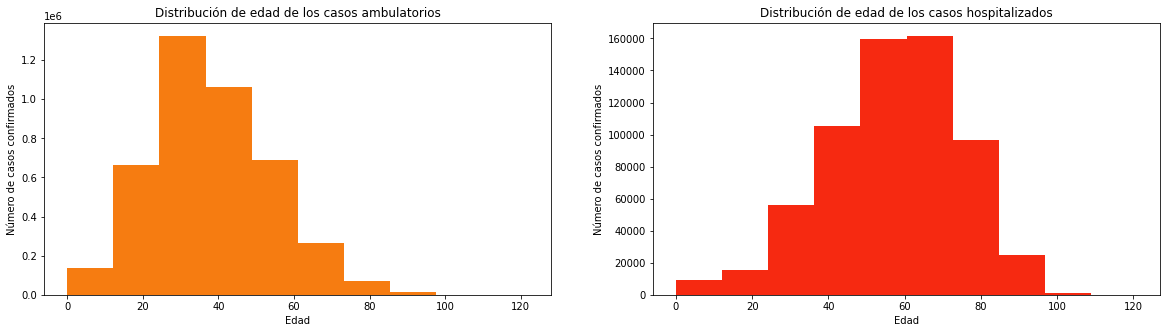

In [36]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0], color="#F67C11")
axs[0].set_title("Distribución de edad de los casos ambulatorios")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1], color="#F62911")
axs[1].set_title("Distribución de edad de los casos hospitalizados")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [37]:
print("Resumen edad de casos ambulatorios")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0])
amb_age

Resumen edad de casos ambulatorios


{'minimo': 0,
 'Q1': 27.0,
 'mediana': 36.0,
 'Q2': 36.0,
 'Q3': 48.0,
 'max': 122,
 'IQR': 21.0,
 'media': 38.06806613036282}

In [38]:
print("Resumen edad de casos hospitalizados")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1])
amb_age

Resumen edad de casos hospitalizados


{'minimo': 0,
 'Q1': 46.0,
 'mediana': 58.0,
 'Q2': 58.0,
 'Q3': 70.0,
 'max': 121,
 'IQR': 24.0,
 'media': 56.994121798621535}

**Se puede apreciar que el grueso de los casos tratados ambulatoriamente están entre los 29 y 51 años de edad mientras que los hospitalizados estan entre los 48 y 70.**

### Distribución por edad de fallecidos

Text(0, 0.5, 'Número de casos confirmados')

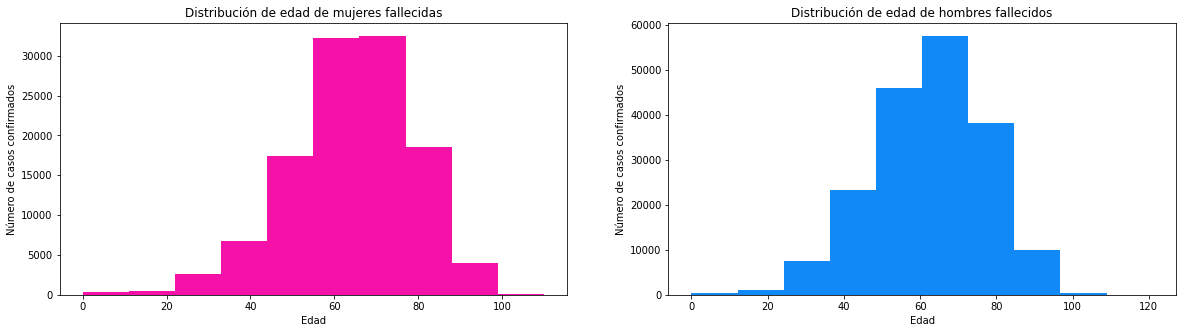

In [39]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)], color="#F611A9")
axs[0].set_title("Distribución de edad de mujeres fallecidas")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)], color="#1189F6")
axs[1].set_title("Distribución de edad de hombres fallecidos")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [40]:
print("Resumen edad en mujeres fallecidas")
female_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)])
female_deceased

Resumen edad en mujeres fallecidas


{'minimo': 0,
 'Q1': 55.0,
 'mediana': 65.0,
 'Q2': 65.0,
 'Q3': 74.0,
 'max': 110,
 'IQR': 19.0,
 'media': 63.808227765443384}

In [41]:
print("Resumen edad en hombres fallecidos")
male_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)])
male_deceased

Resumen edad en hombres fallecidos


{'minimo': 0,
 'Q1': 53.0,
 'mediana': 63.0,
 'Q2': 63.0,
 'Q3': 73.0,
 'max': 121,
 'IQR': 20.0,
 'media': 62.48508653825273}

**El 50% de los fallecidos parece estar entre los 55 y 74 años de edad**

### Comparación de mortalidad en hombres y mujeres

In [42]:
table = pd.crosstab(data_filtered.SEXO_, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table

FALLECIDO,0,1,MORTALIDAD
SEXO_,,,
HOMBRE,2177867,184196,0.077981
MUJER,2377900,114855,0.046076


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

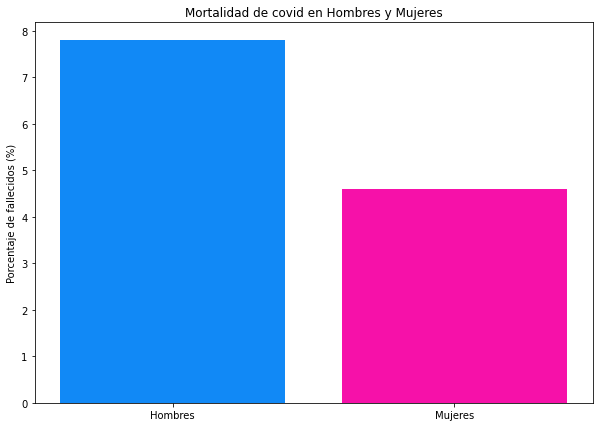

In [43]:
plt.figure(figsize = (10,7))
plt.bar(["Hombres"], table["MORTALIDAD"][0]*100, color = "#1189F6")
plt.bar(["Mujeres"], table["MORTALIDAD"][1]*100, color = "#F611A9")
plt.title("Mortalidad de covid en Hombres y Mujeres")
plt.ylabel("Porcentaje de fallecidos (%)")

## Mortalidad por estado y por sector

### Mortalidad por estado


In [44]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
ESTADO,,,
BS,86097,2458,0.027757
TC,171097,5233,0.029677
DF,1323854,52709,0.038290
SP,146102,6942,0.045360
QT,119213,5899,0.047150
DG,58656,2990,0.048503
QR,79055,4100,0.049306
CM,43044,2242,0.049508
NL,244200,14118,0.054654


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

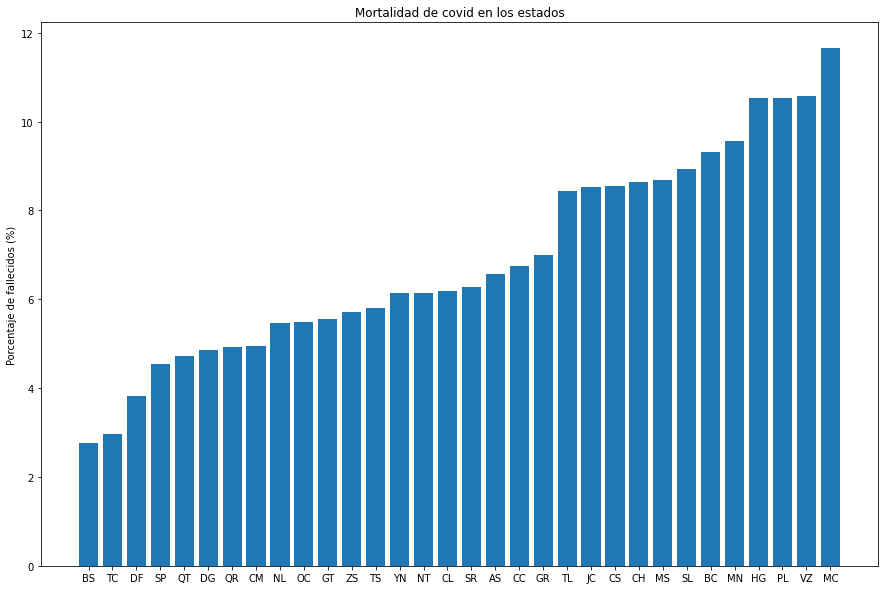

In [45]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid en los estados")
plt.ylabel("Porcentaje de fallecidos (%)")

### Mortalidad por sector de la salud

In [46]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
SECTOR_ATENDIDO,,,
DIF,1058,8,0.007505
MUNICIPAL,4224,135,0.030970
CRUZ ROJA,935,31,0.032091
SSA,2299023,87201,0.036544
PRIVADA,135733,5982,0.042211
ESTATAL,49108,4148,0.077888
SEMAR,11242,969,0.079355
IMSS-BIENESTAR,29624,2592,0.080457
IMSS,1857640,167613,0.082762


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

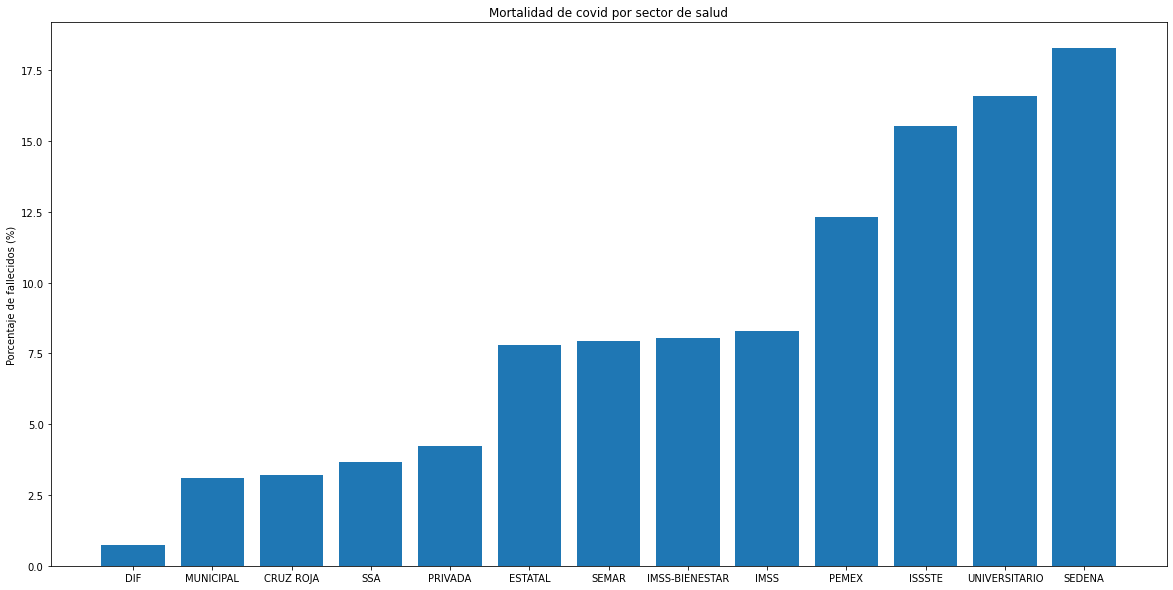

In [47]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid por sector de salud")
plt.ylabel("Porcentaje de fallecidos (%)")

## Proporcion de enfermos grave de covid por estado y por sector

### Proporción de enfermos graves por estado

In [48]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
ESTADO,,,
BS,84429,4126,0.046593
DG,58476,3170,0.051423
TC,166159,10171,0.057682
CL,123563,8847,0.066815
ZS,57125,4343,0.070655
DF,1278050,98513,0.071564
TS,120739,9374,0.072045
NL,239368,18950,0.073359
SP,141675,11369,0.074286


Text(0, 0.5, 'Porcentaje de enfermos (%)')

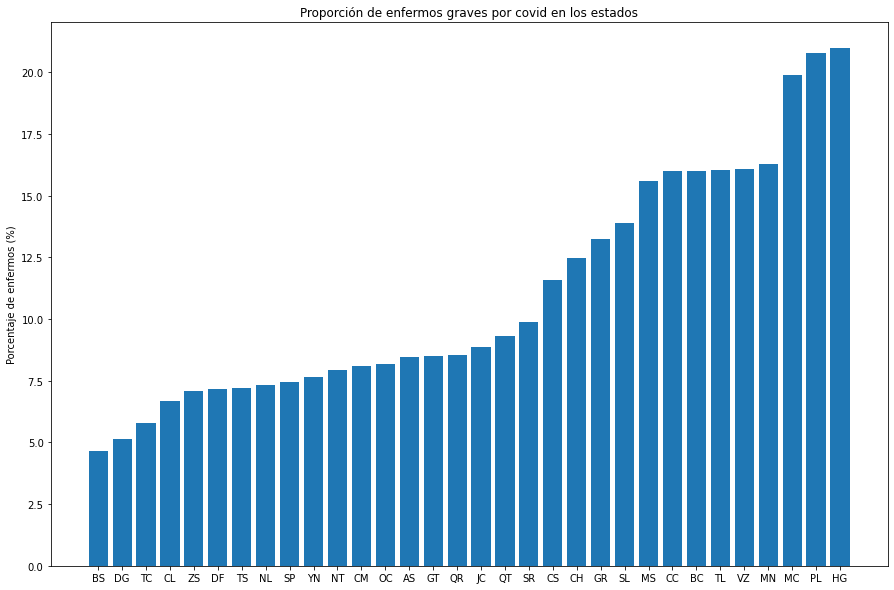

In [49]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por covid en los estados")
plt.ylabel("Porcentaje de enfermos (%)")

### Proporción de enfermos graves por sector de salud

In [50]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
SECTOR_ATENDIDO,,,
CRUZ ROJA,923,43,0.044513
DIF,1012,54,0.050657
MUNICIPAL,4079,280,0.064235
SSA,2204737,181487,0.076056
IMSS,1820335,204918,0.101181
IMSS-BIENESTAR,27379,4837,0.150143
PRIVADA,118719,22996,0.162269
ESTATAL,43015,10241,0.192298
SEMAR,9730,2481,0.203177


Text(0, 0.5, 'Porcentaje de enfermos graves (%)')

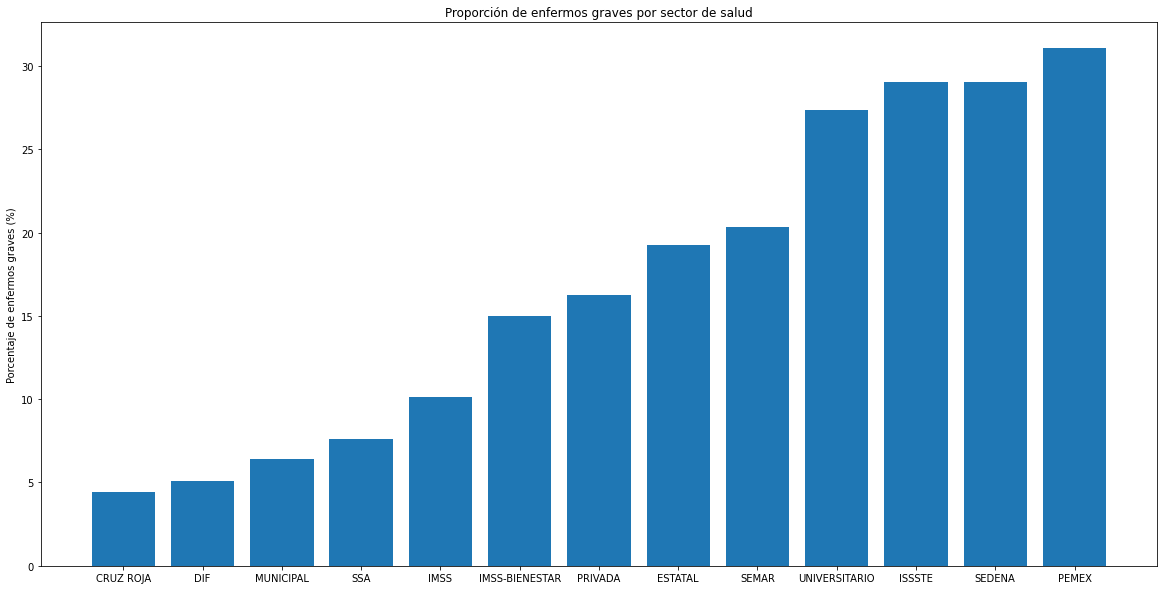

In [51]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por sector de salud")
plt.ylabel("Porcentaje de enfermos graves (%)")

## Mortalidad por días de espera
Se obtendrá la mortalidad según los días entre que el paciente presento síntomas y cuando se atendió en una unidad de salud.

Text(0.5, 0, 'Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud')

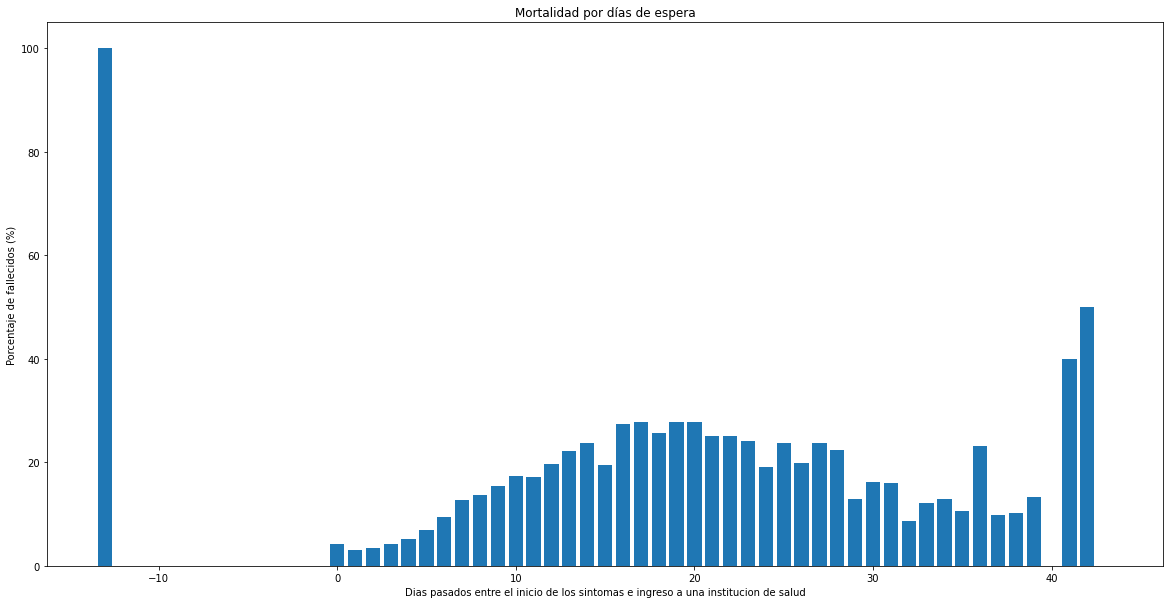

In [52]:
table = pd.crosstab(data_filtered.TIEMPO_ESPERA, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["TIEMPO_ESPERA"])
table = table[0:45]

plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad por días de espera")
plt.ylabel("Porcentaje de fallecidos (%)")
plt.xlabel("Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud")

Se puede ver que aumenta la mortalidad entre más días de espera.

##  Mortalidad y Positividad a lo largo de la pandemia
Se obtendrá la mortalidad y positividad por semana desde la primera semana del 2020 (Se registraban solamente casos sospechosos los primeros meses del 2020)

In [53]:
covid_df["HOSPITALIZADO"] = covid_df["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)
covid_df[["TIPO_PACIENTE","HOSPITALIZADO"]].sample(3)

,TIPO_PACIENTE,HOSPITALIZADO
10840785,1,0
6935342,1,0
1513682,1,0


In [54]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(covid_df, dates)
cases_by_day = pd.DataFrame(cases_by_day)

In [55]:
#data_filtered["FECHA_INGRESO"] = pd.to_datetime(data_filtered["FECHA_INGRESO"], format = "%Y-%m-%d")
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], format = "%Y-%m-%d")

### Gráfica de casos

Text(0.5, 1.0, 'GRAFICA NACIONAL 2022-01-29')

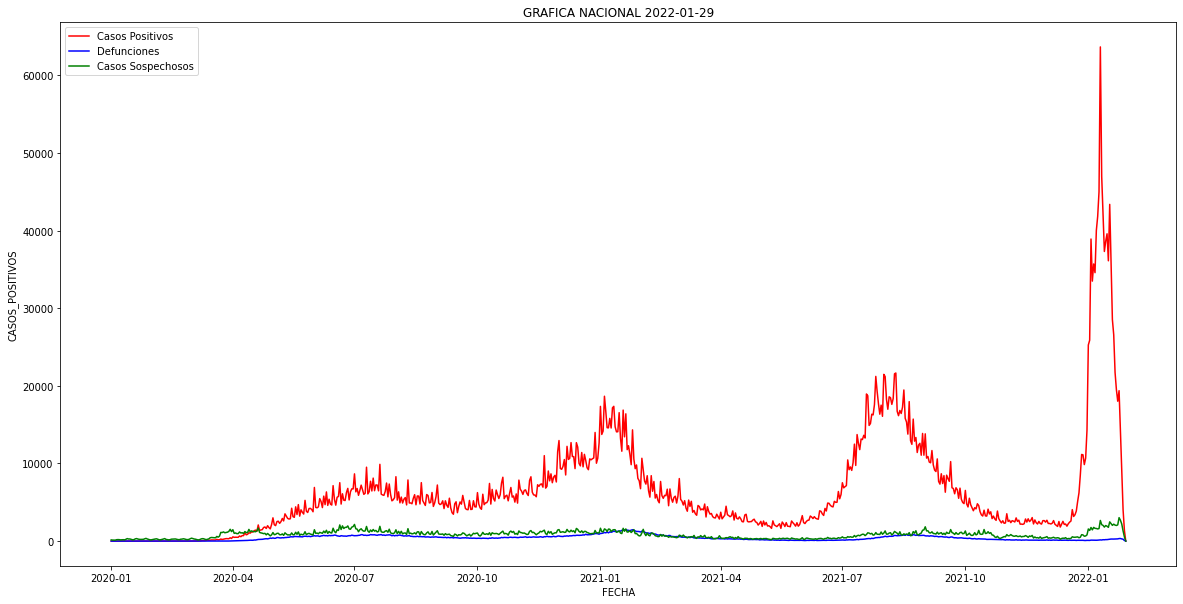

In [56]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
sns.lineplot(x = cases_by_day["FECHA"], y = cases_by_day["CASOS_POSITIVOS"], label = "Casos Positivos", color = "r", ax = ax)
sns.lineplot(x = cases_by_day["FECHA"], y = cases_by_day["DEFUNCIONES"], label = "Defunciones", color = "b", ax = ax)
sns.lineplot(x = cases_by_day["FECHA"], y = cases_by_day["CASOS_SOSPECHOSOS"], label = "Casos Sospechosos", color = "g", ax = ax)
ax.set_title(f"GRAFICA NACIONAL {date}")

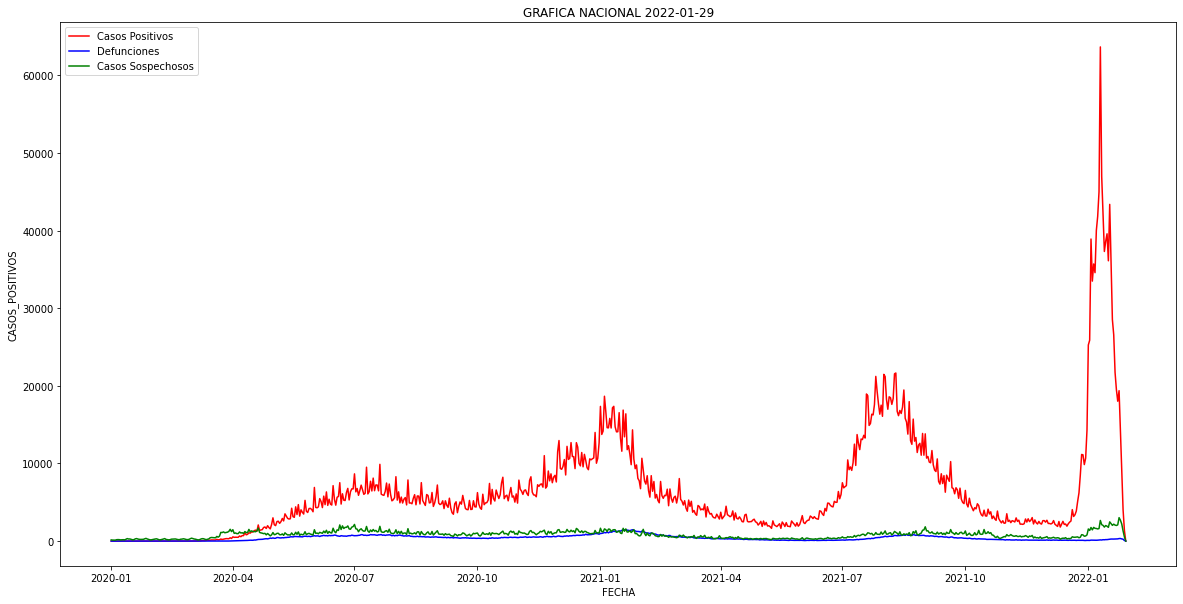

In [57]:
covid.createGraph_("NACIONAL", cases_by_day, date)

In [58]:
cases_by_day.sample(4)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES
723,2021-12-24,5100,12401,540,107,278
507,2021-05-22,1899,8712,294,85,214
354,2020-12-20,11174,14793,1252,778,2219
201,2020-07-20,9887,9976,1901,804,2297


In [59]:
hosp = covid_df[(covid_df["HOSPITALIZADO"] == 1) & (covid_df["RESULTADO"] == 1)].groupby(["FECHA_SINTOMAS","RESULTADO"])["RESULTADO"].count()
pd.DataFrame(hosp)

,,RESULTADO
FECHA_SINTOMAS,RESULTADO,
2020-02-22,1,1
2020-02-26,1,1
2020-02-28,1,1
2020-02-29,1,1
2020-03-01,1,3
...,...,...
2022-01-24,1,865
2022-01-25,1,681
2022-01-26,1,435


### Gráfica de Hospitalizaciones

Text(0, 0.5, 'HOSPITALIZACIONES')

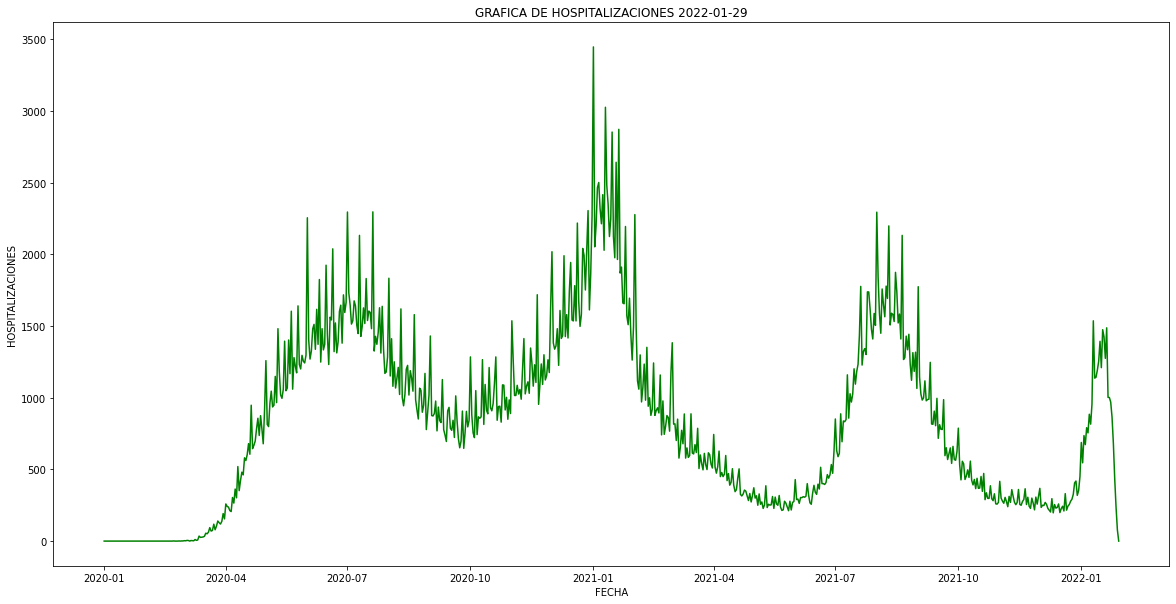

In [60]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
sns.lineplot(x = cases_by_day["FECHA"], y = cases_by_day["HOSPITALIZACIONES"], color = "g", ax = ax)
ax.set_title(f"GRAFICA DE HOSPITALIZACIONES {date}")
ax.set_ylabel("HOSPITALIZACIONES")

### Separación de semanas

In [61]:
cases_by_day.dtypes

FECHA                datetime64[ns]
CASOS_POSITIVOS               int64
CASOS_NEGATIVOS               int64
CASOS_SOSPECHOSOS             int64
DEFUNCIONES                   int64
HOSPITALIZACIONES             int64
dtype: object

In [62]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [63]:
cases_by_day.sample(10)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES,SEMANA
12,2020-01-13,0,246,322,0,0,1
394,2021-01-29,8079,18837,798,1241,1445,56
624,2021-09-16,6295,11091,829,515,717,89
683,2021-11-14,2239,10241,597,126,269,97
120,2020-04-30,2145,2615,805,354,919,17
546,2021-06-30,6001,14227,423,130,628,78
178,2020-06-27,5299,4428,1563,699,1381,25
265,2020-09-22,4195,6826,831,431,715,37
66,2020-03-07,21,210,180,0,3,9
638,2021-09-30,4830,14276,986,365,625,91


In [64]:
cases_by_day.tail(3)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES,SEMANA
757,2022-01-27,4021,3816,1304,245,237,108
758,2022-01-28,1366,2002,536,74,78,108
759,2022-01-29,0,0,1,0,0,108


In [65]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()
cases_by_week.sample(5)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES
SEMANA,,,,,
22,34064,32154,7521,4713,9917
55,86381,165263,9124,9888,13739
11,1329,6409,4819,10,548
48,69958,103241,8525,4383,9815
74,18865,68321,2096,642,2069


### Mortalidad

In [66]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]
cases_by_week.tail(10)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES,MORTALIDAD
SEMANA,,,,,,
99,16913,87284,3061,832,1889,0.049193
100,16556,87975,3067,875,1855,0.052851
101,15105,80288,2552,819,1632,0.054220
102,18599,78308,2780,749,1685,0.040271
103,49311,98303,4090,708,2220,0.014358
104,158339,152532,8207,673,3764,0.004250
105,307715,192045,12984,898,6877,0.002918
106,273173,129202,14251,1449,9092,0.005304
107,147961,80180,16077,2031,7284,0.013727


In [67]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])
cases_by_week.tail()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES,MORTALIDAD,DIA
SEMANA,,,,,,,
104,158339,152532,8207,673,3764,0.004250,2021-12-29
105,307715,192045,12984,898,6877,0.002918,2022-01-05
106,273173,129202,14251,1449,9092,0.005304,2022-01-12
107,147961,80180,16077,2031,7284,0.013727,2022-01-19
108,14176,12379,4045,599,750,0.042255,2022-01-26


In [68]:
cases_by_week.tail()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,HOSPITALIZACIONES,MORTALIDAD,DIA
SEMANA,,,,,,,
104,158339,152532,8207,673,3764,0.004250,2021-12-29
105,307715,192045,12984,898,6877,0.002918,2022-01-05
106,273173,129202,14251,1449,9092,0.005304,2022-01-12
107,147961,80180,16077,2031,7284,0.013727,2022-01-19
108,14176,12379,4045,599,750,0.042255,2022-01-26


Text(0, 0.5, 'Mortalidad en porcentaje (%)')

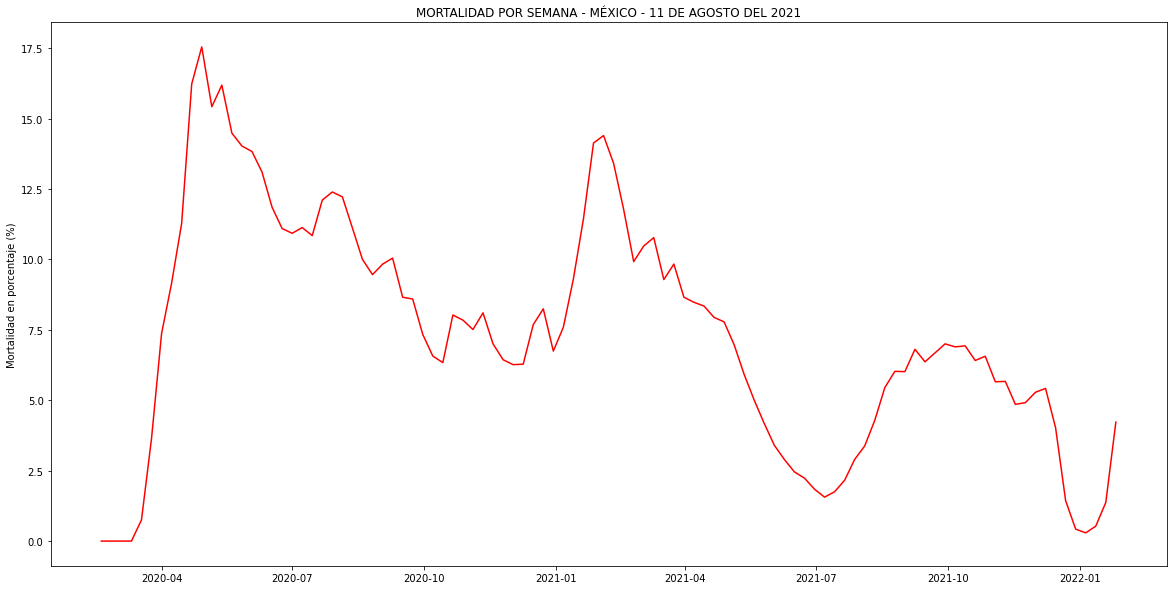

In [69]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

Text(0, 0.5, 'Mortalidad (%)')

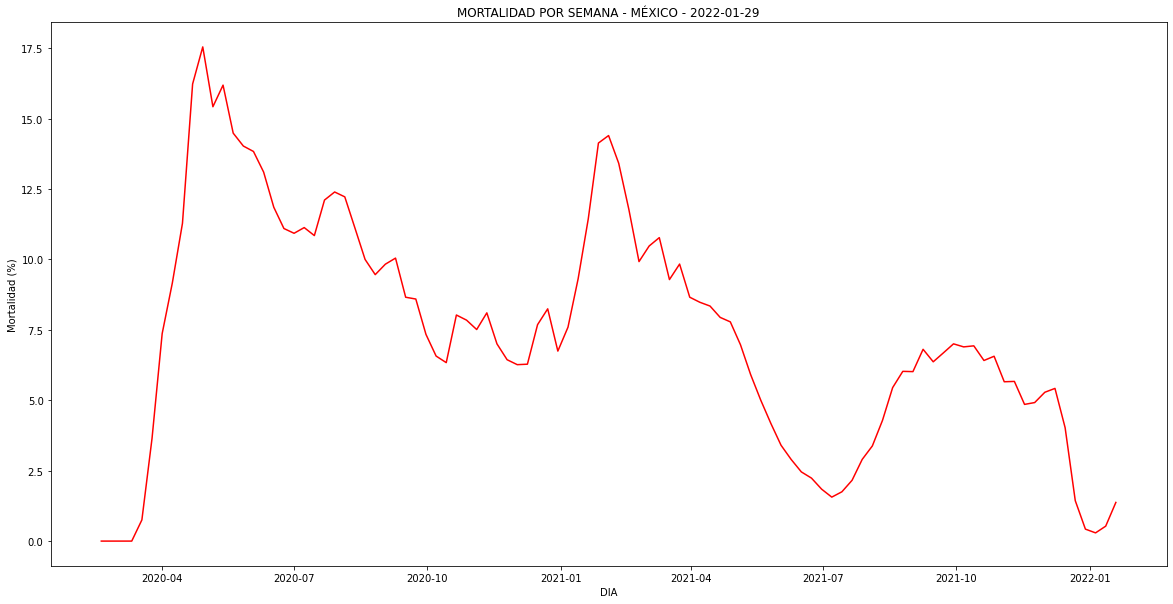

In [70]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
sns.lineplot(x = cases_by_week["DIA"][:-1], y = cases_by_week["MORTALIDAD"][:-1]*100, color = "r", ax = ax)
ax.set_title(f"MORTALIDAD POR SEMANA - MÉXICO - {date}")
ax.set_ylabel("Mortalidad (%)")

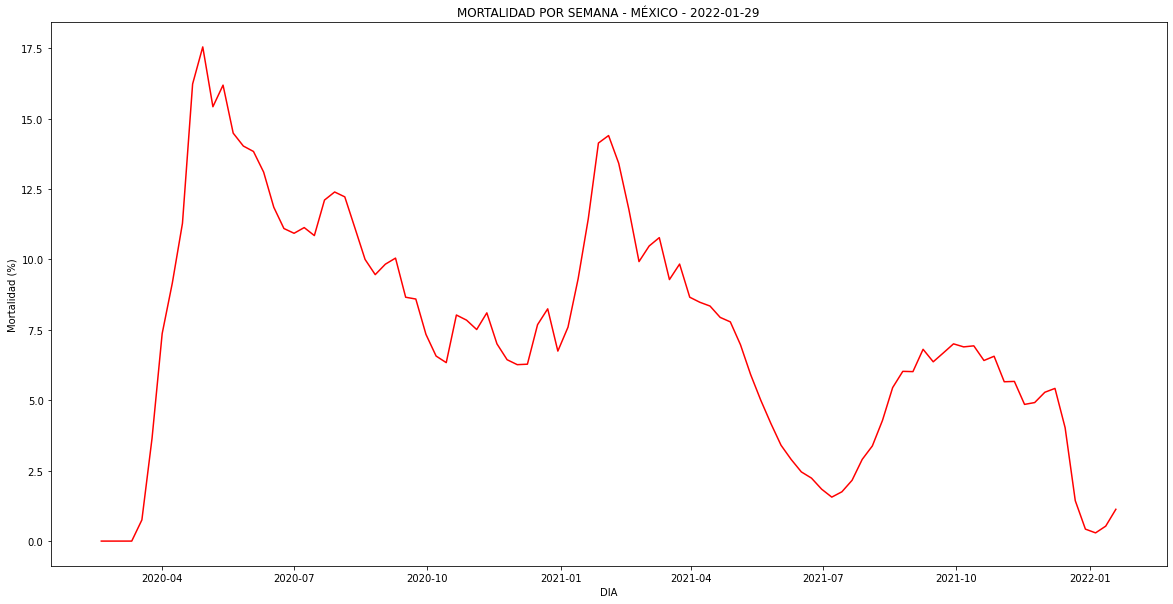

In [72]:
covid.mortality_rate_graph_("MÉXICO",cases_by_day[:-7], date)

Se puede apreciar que los maximos de la mortalidad coinciden con los picos de las olas que han habido en México.


### Positividad

In [150]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

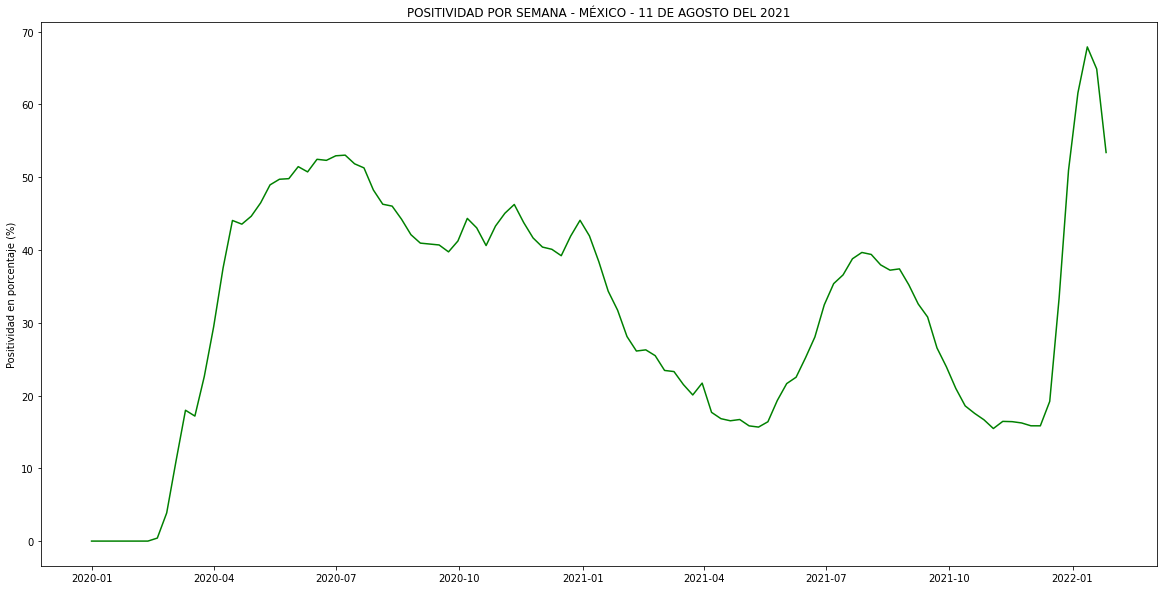

In [151]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

Al igual que con la mortalidad, la positividad cambió durante la pandemia de covid y sus puntos más altos coinciden con los picos de las olas de la epidemia que han habido.

## Guardado Dataset
Se guarda el dataset después de ser limpiado y con datos procesados

In [ ]:
dataset_file = "210727COVID19MEXICO_filtered.csv"
data_filtered.to_csv(os.path.join(main_dataset_path, dataset_file))

## Efecto de las vacunas en los grupos de población

In [ ]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,PAIS_ORIGEN,UCI,RESULTADO,TIEMPO_ESPERA,FALLECIDO,ENFERMEDAD_GRAVE,HOSPITALIZADO,SEXO_,SECTOR_ATENDIDO,ESTADO
1176740,2022-01-18,c06ee1,1,6,9,2,15,9,7,2,...,97,0,1,7,1,1,1,HOMBRE,ISSSTE,DF
1450548,2022-01-18,6de930,2,4,9,2,9,9,8,1,...,97,0,1,4,0,0,0,HOMBRE,IMSS,DF
362038,2022-01-18,26755b,2,12,9,1,9,9,5,1,...,97,0,1,0,0,0,0,MUJER,SSA,DF
3190198,2022-01-18,3fe8e5,2,4,21,1,21,21,114,1,...,97,0,1,1,0,0,0,MUJER,IMSS,PL
3836386,2022-01-18,ea0f0a,2,12,27,1,27,27,4,1,...,97,0,1,5,0,0,0,MUJER,SSA,TC


In [ ]:
data_filtered.shape

(4389330, 48)

Se separará el dataframe `data_filtered` en 6 grupos:
* Mayores de 60 años
* Entre 50 y 59 años
* Entre 40 y 49 años
* Entre 30 y 39 años
* Entre 20 y 29 años
* Menores de 20 años

In [ ]:
data_by_age = {}

In [ ]:
data_by_age[">60"] = covid_df[covid_df["EDAD"] >= 60].copy()

In [ ]:
data_by_age["50-59"] = covid_df[(covid_df["EDAD"] >= 50) & (covid_df["EDAD"] <= 59)].copy()

In [ ]:
data_by_age["40-49"] = covid_df[(covid_df["EDAD"] >= 40) & (covid_df["EDAD"] <= 49)].copy()

In [ ]:
data_by_age["30-39"] = covid_df[(covid_df["EDAD"] >= 30) & (covid_df["EDAD"] <= 39)].copy()

In [ ]:
data_by_age["20-29"] = covid_df[(covid_df["EDAD"] >= 20) & (covid_df["EDAD"] <= 29)].copy()

In [ ]:
data_by_age["<20"] = covid_df[covid_df["EDAD"] <= 19].copy()

In [ ]:
keys = data_by_age.keys()
for key in keys:
  print(f"GRUPO EDAD {key}")
  comulative_cases = covid.getComulativeCases(data_by_age[key])
  covid.printCumulativeCases(comulative_cases, date)

GRUPO EDAD >60
Fecha de actualización: 2021-08-11

  Total de casos estudiados: 1598948

  Casos Positivos a SARS-CoV-2: 657690

  Casos No Positivos a SARS-CoV-2: 859480

  Casos Con Resultado Pendiente: 81778

  Defunciones Positivas a SARS-CoV-2: 186387

  Tasa de Letalidad: 28.340%

  Tasa de Positividad : 43.350%

GRUPO EDAD 50-59
Fecha de actualización: 2021-08-11

  Total de casos estudiados: 1797127

  Casos Positivos a SARS-CoV-2: 641622

  Casos No Positivos a SARS-CoV-2: 1063515

  Casos Con Resultado Pendiente: 91990

  Defunciones Positivas a SARS-CoV-2: 61266

  Tasa de Letalidad: 9.549%

  Tasa de Positividad : 37.629%

GRUPO EDAD 40-49
Fecha de actualización: 2021-08-11

  Total de casos estudiados: 2460010

  Casos Positivos a SARS-CoV-2: 856690

  Casos No Positivos a SARS-CoV-2: 1487925

  Casos Con Resultado Pendiente: 115395

  Defunciones Positivas a SARS-CoV-2: 34146

  Tasa de Letalidad: 3.986%

  Tasa de Positividad : 36.539%

GRUPO EDAD 30-39
Fecha de actualiz

In [ ]:
table_age = pd.crosstab(data_filtered.EDAD,data_filtered.FALLECIDO)
table_age["MORTALIDAD"] = table_age[1]/(table_age[0]+table_age[1])*100
table_age = table_age.sort_values(by = ["EDAD"])

In [ ]:
table_age["MORTALIDAD"].values

array([ 3.79907134,  1.72783284,  0.66382172,  0.50080775,  0.40358744,
        0.19241341,  0.26240458,  0.26299179,  0.24349129,  0.17889088,
        0.19352438,  0.15521925,  0.24437656,  0.21299759,  0.14124294,
        0.21233004,  0.24474669,  0.31471037,  0.25073785,  0.2514636 ,
        0.29852199,  0.30650906,  0.3183441 ,  0.31930901,  0.37995624,
        0.40373734,  0.54681641,  0.53601031,  0.63614388,  0.73112776,
        0.82860758,  0.89005688,  1.00392885,  1.10355253,  1.29209244,
        1.48756384,  1.63266585,  1.81601854,  2.09676568,  2.17762826,
        2.41202635,  2.64734797,  3.0406694 ,  3.30200569,  3.75287788,
        4.12174865,  4.46551904,  4.81146322,  5.22457652,  5.64884014,
        6.1229232 ,  6.78608194,  7.50842039,  8.25741684,  8.88325275,
        9.96583144, 11.13039995, 11.92769403, 12.87496978, 14.04275057,
       15.72560119, 17.1851819 , 18.88      , 20.435287  , 21.29256092,
       23.43780856, 24.05262533, 25.37463795, 27.54589273, 28.60

Text(0.5, 1.0, 'LETALIDAD POR EDAD')

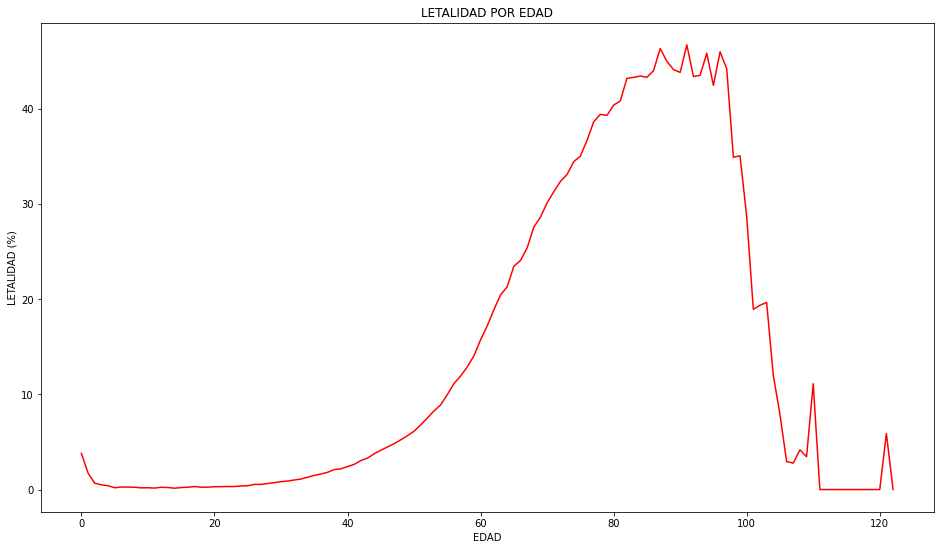

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

sns.lineplot(x = table_age.index, y = table_age["MORTALIDAD"].values, ax = ax, color = "red")
ax.set_ylabel("LETALIDAD (%)")
ax.set_title("LETALIDAD POR EDAD")

### Graficas de casos, mortalidad y positividad por grúpos de edad
Se espera ver una disminución de la mortalidad y casos en los grupos de edad que ya han sido vacunados

#### Mayores de 60 años

In [ ]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age[">60"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

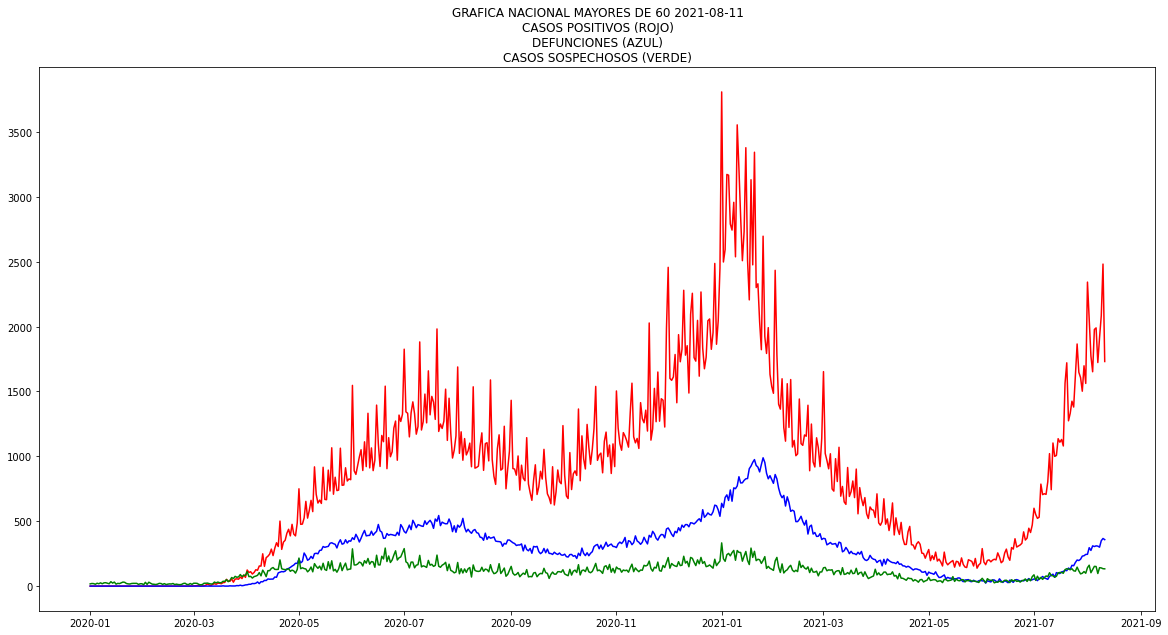

In [ ]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MAYORES DE 60 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [ ]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [ ]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [ ]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [ ]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

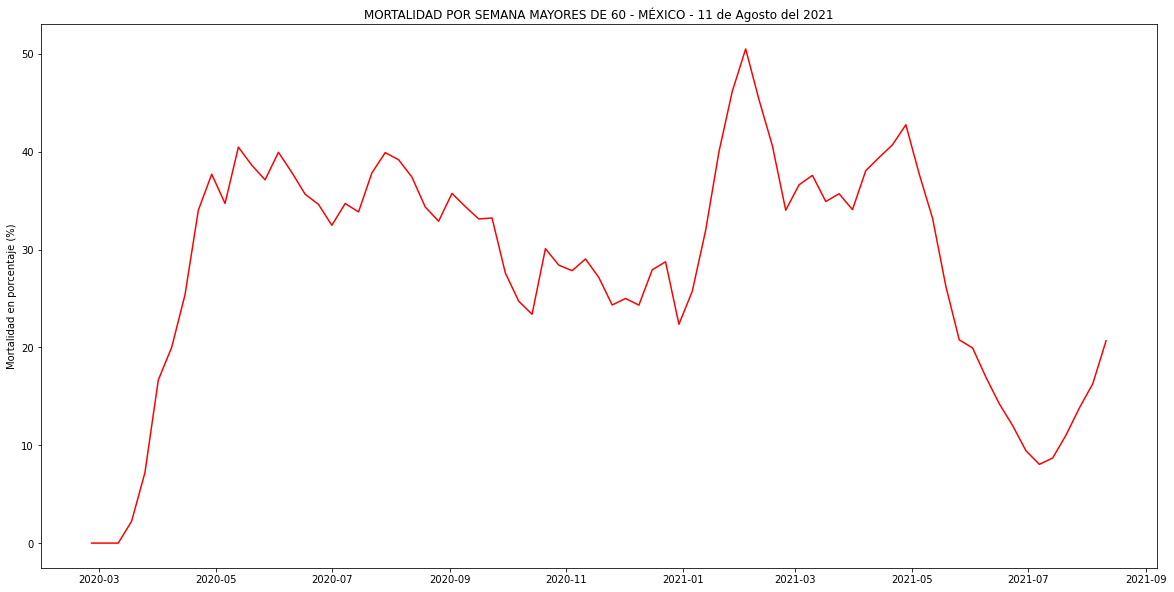

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 11 de Agosto del 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [ ]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

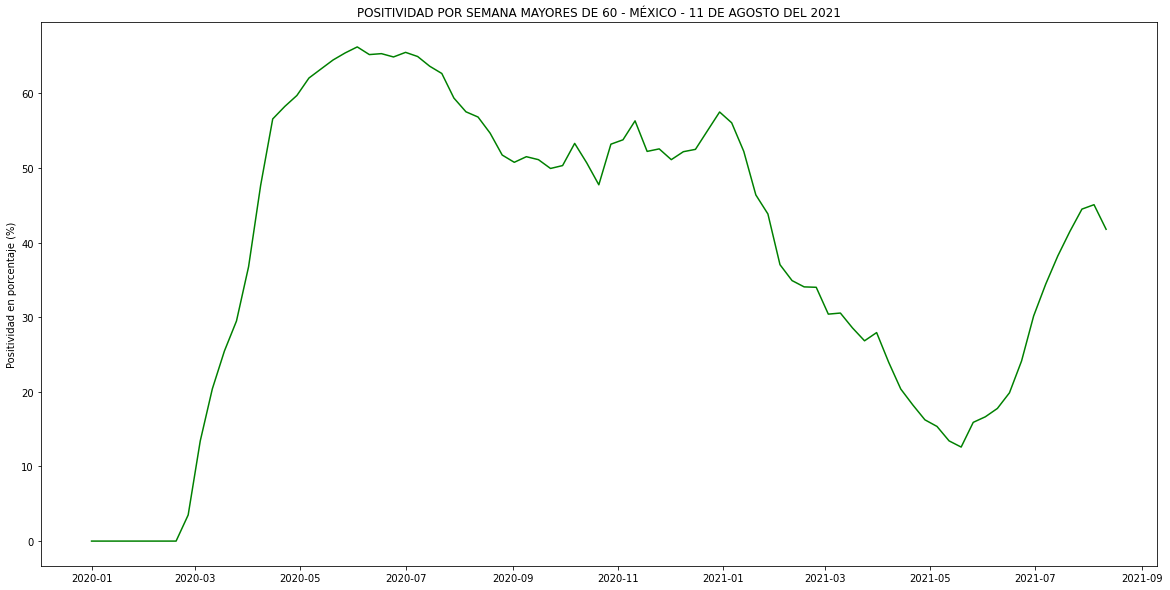

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 50 y 59 años

In [ ]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["50-59"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

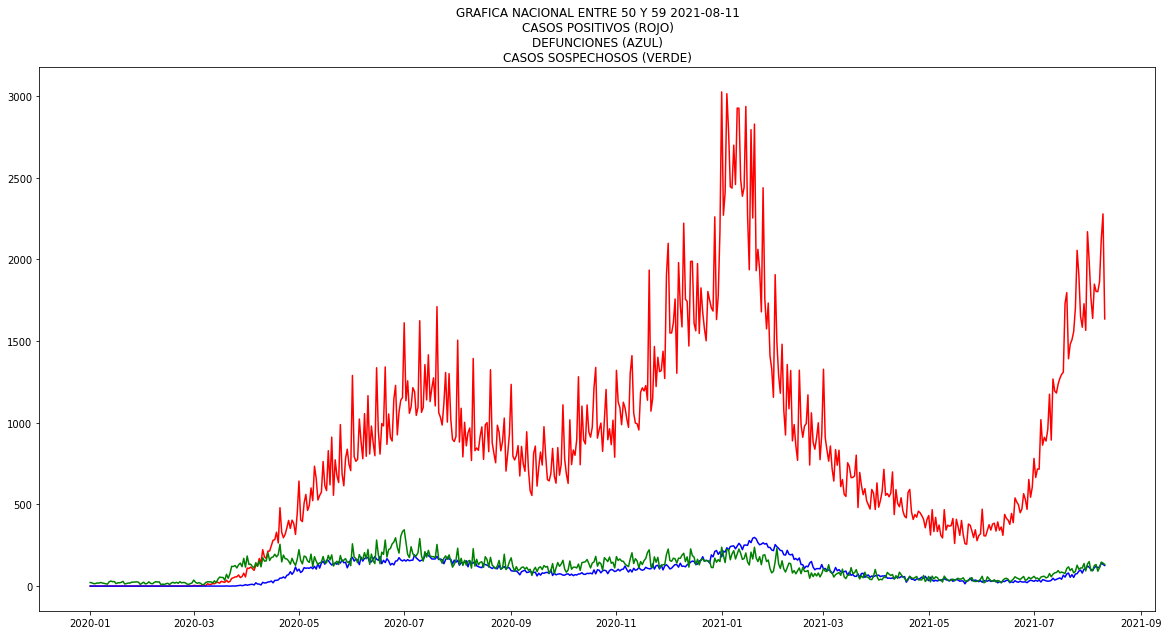

In [ ]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 50 Y 59 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [ ]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [ ]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [ ]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [ ]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

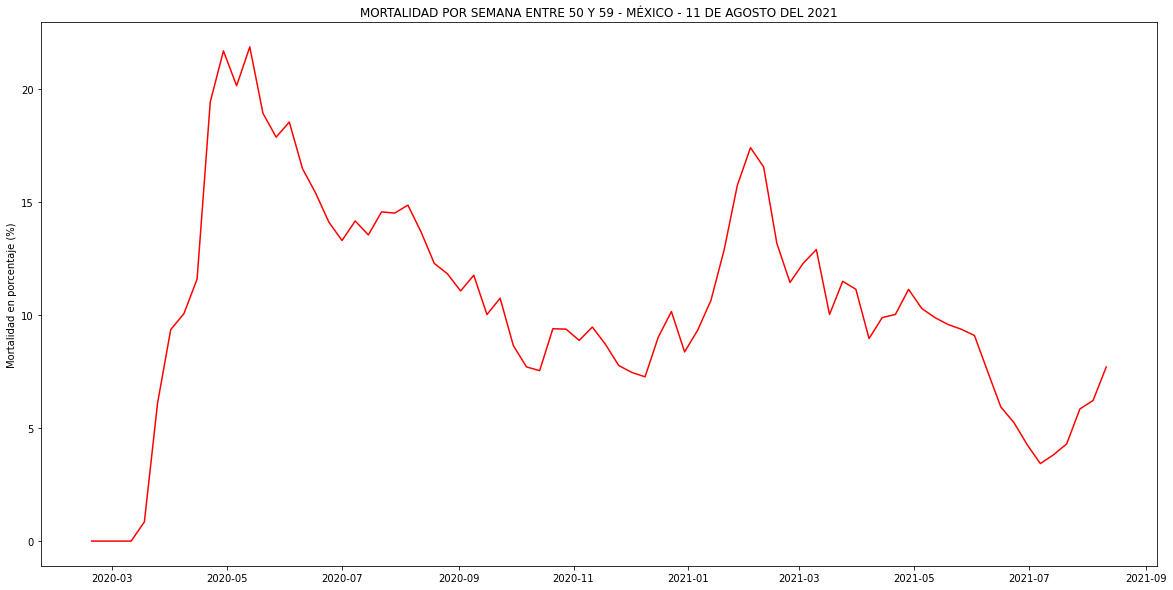

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 50 Y 59 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [ ]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

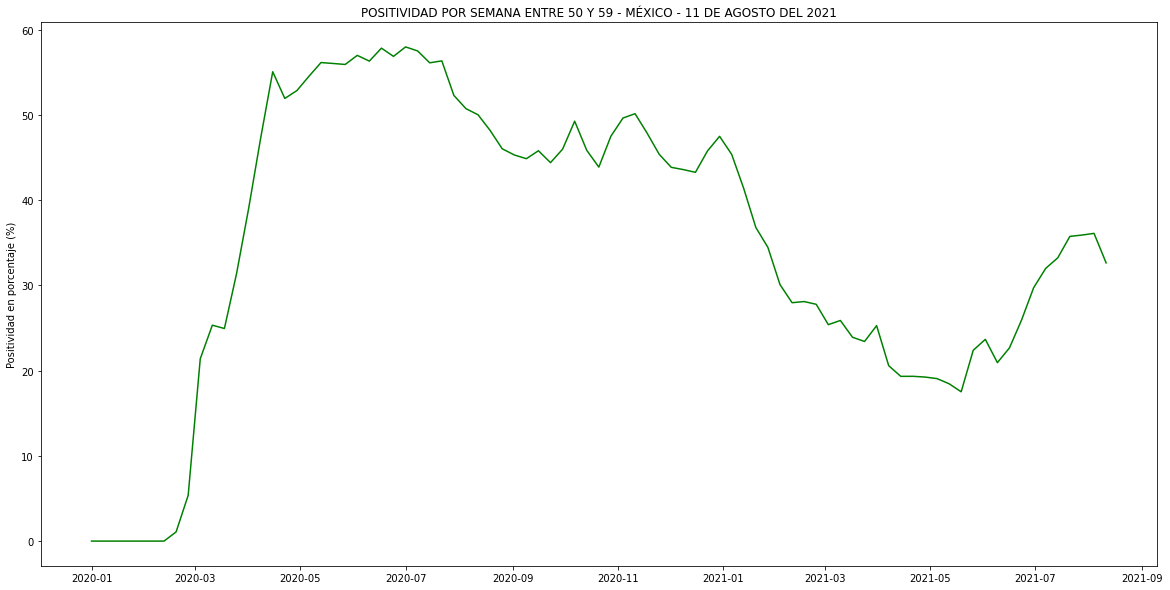

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 50 Y 59 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 40 y 49 años

In [ ]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["40-49"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

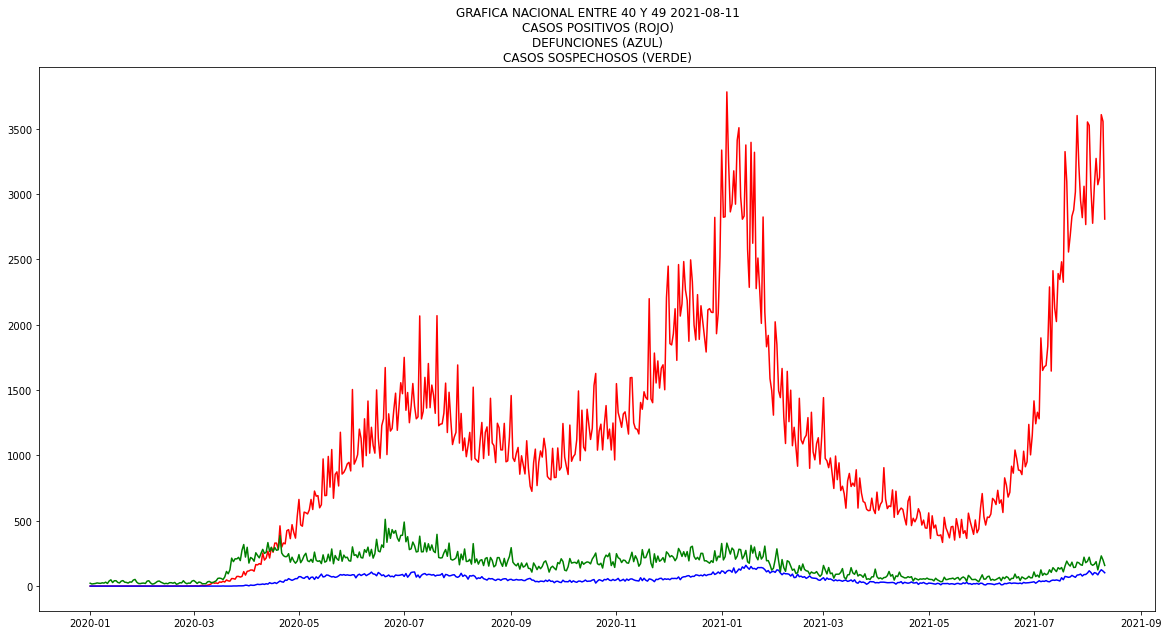

In [ ]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 40 Y 49 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [ ]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [ ]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [ ]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [ ]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

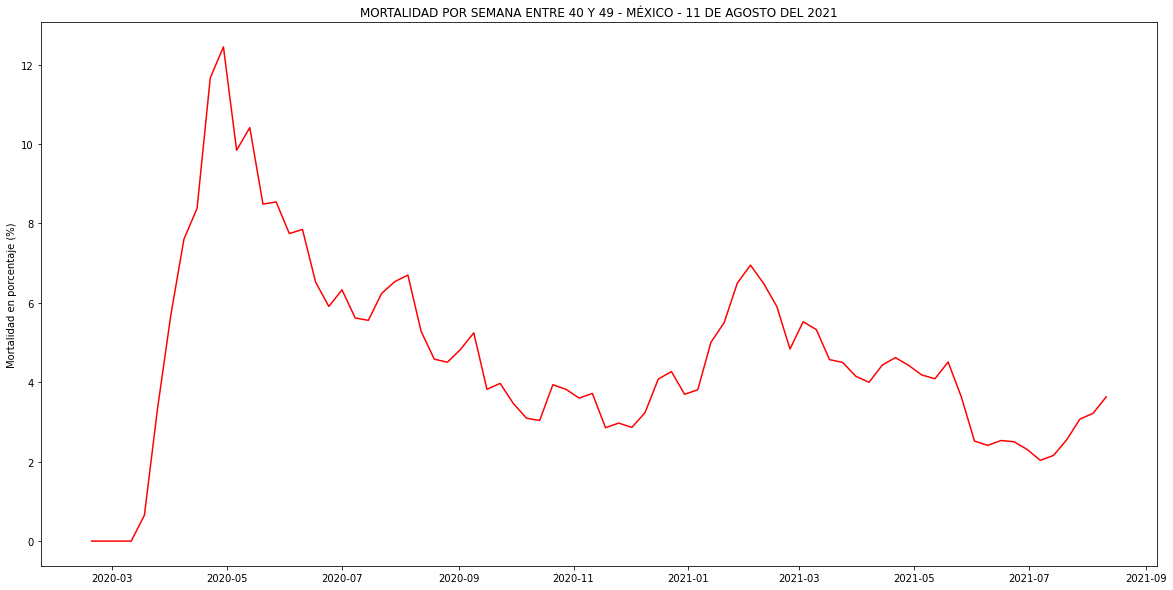

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 40 Y 49 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [ ]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

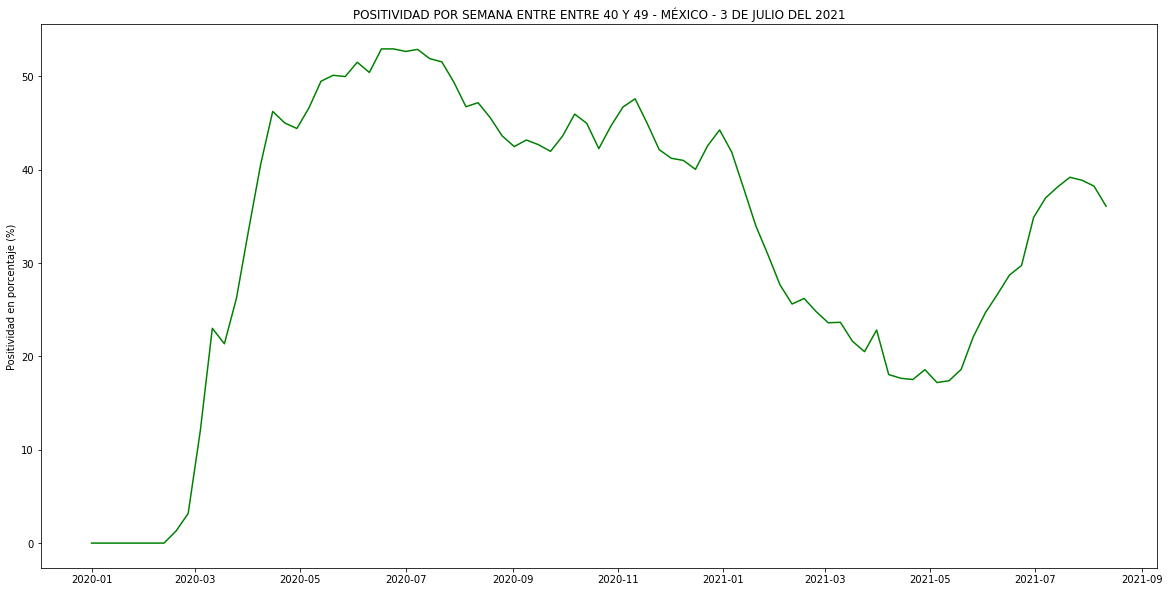

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE ENTRE 40 Y 49 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 30 y 39 años

In [ ]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["30-39"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

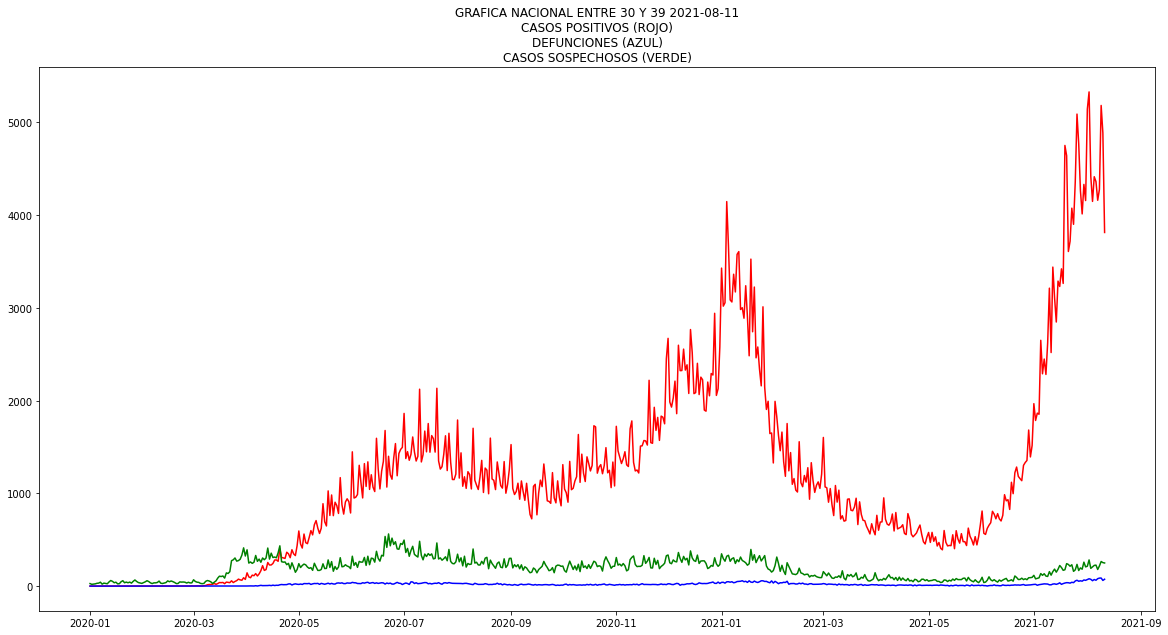

In [ ]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 30 Y 39 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [ ]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [ ]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [ ]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [ ]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

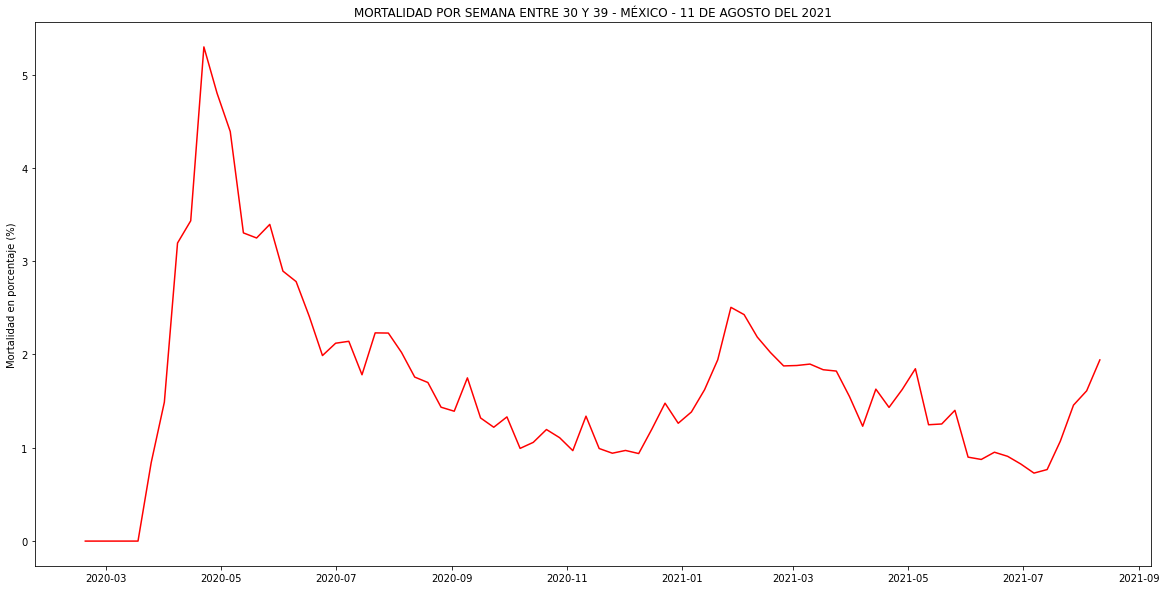

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [ ]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

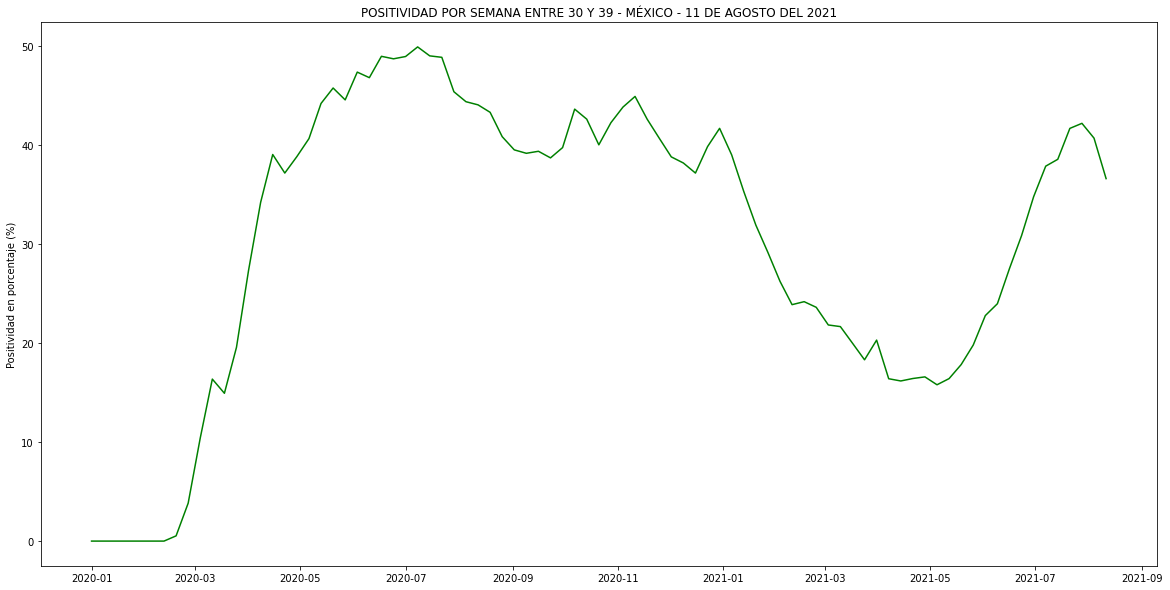

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 20 y 29 años

In [ ]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["20-29"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

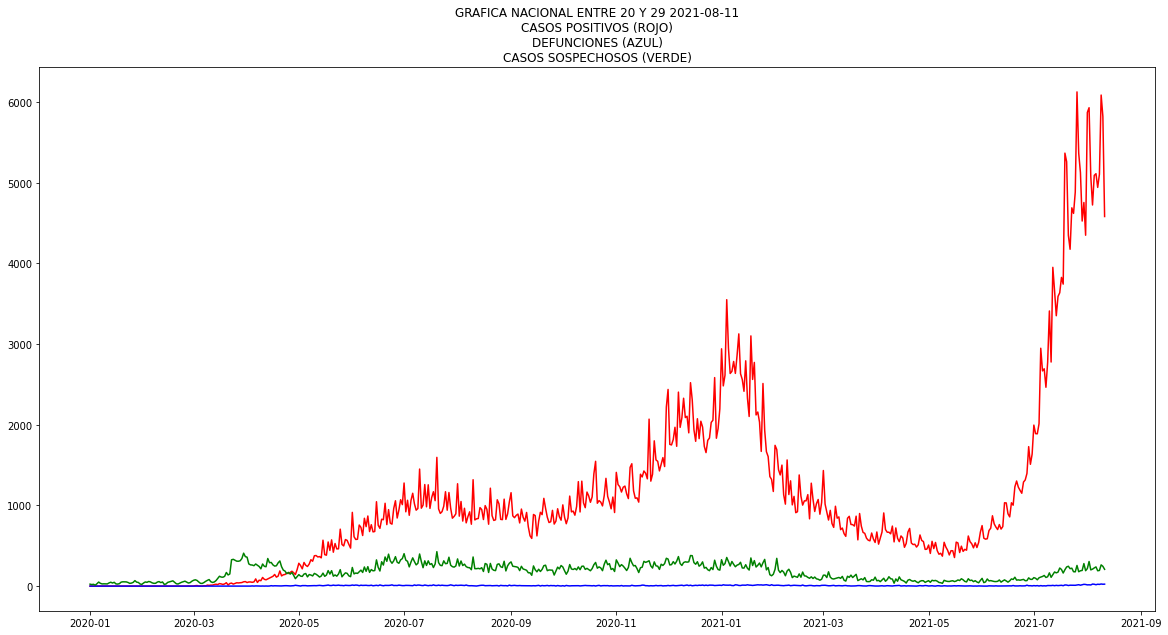

In [ ]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 20 Y 29 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [ ]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [ ]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [ ]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [ ]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

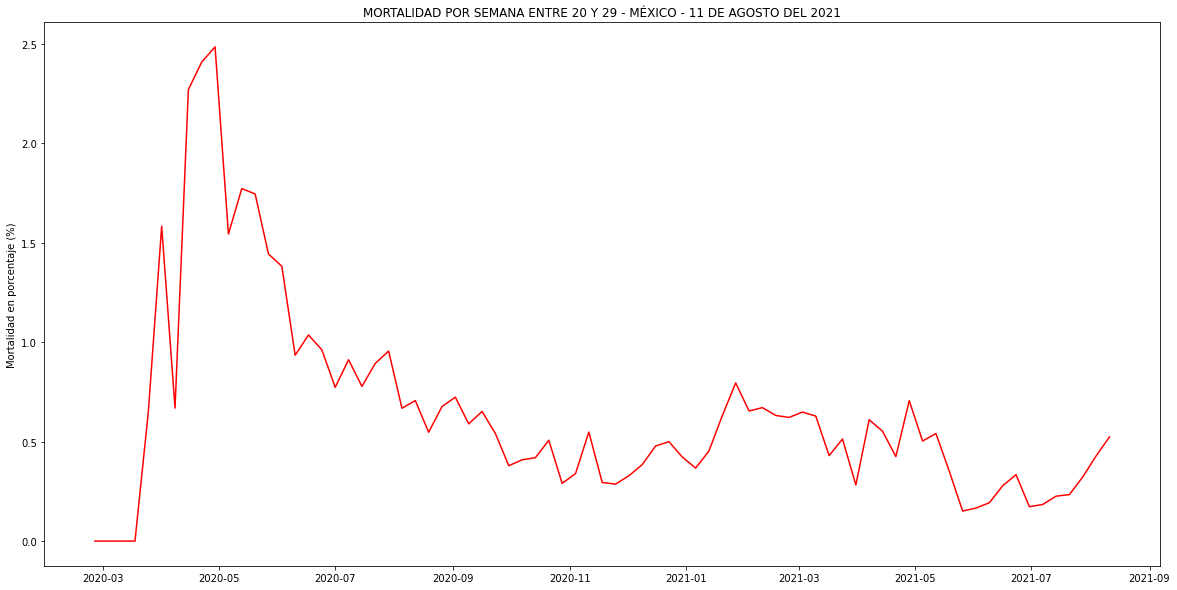

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [ ]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

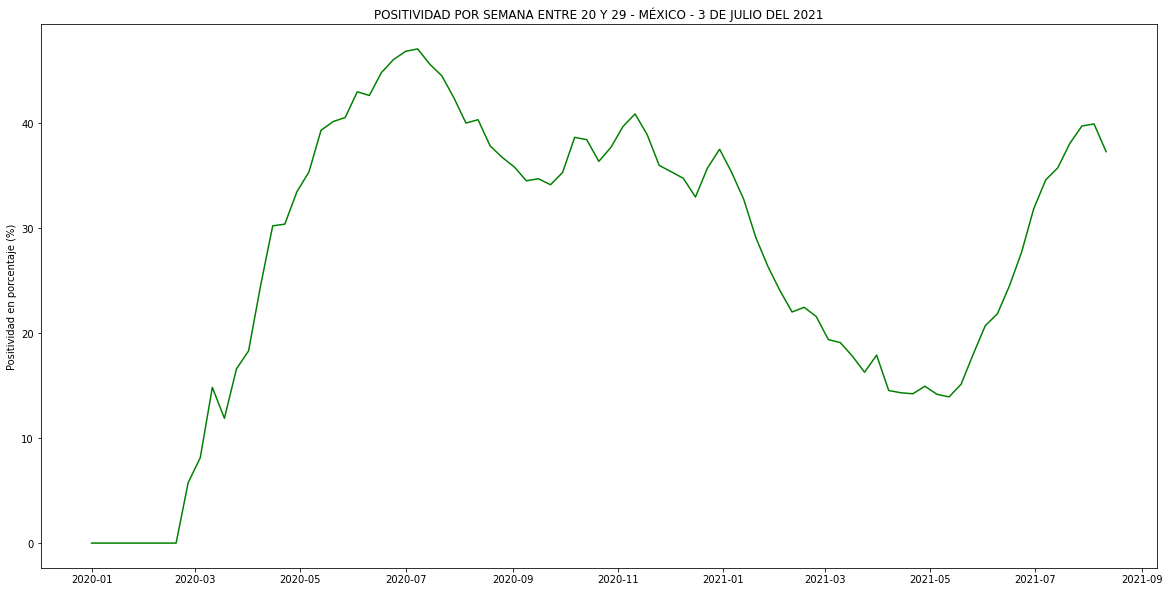

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Menores de 20 años

In [ ]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["<20"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

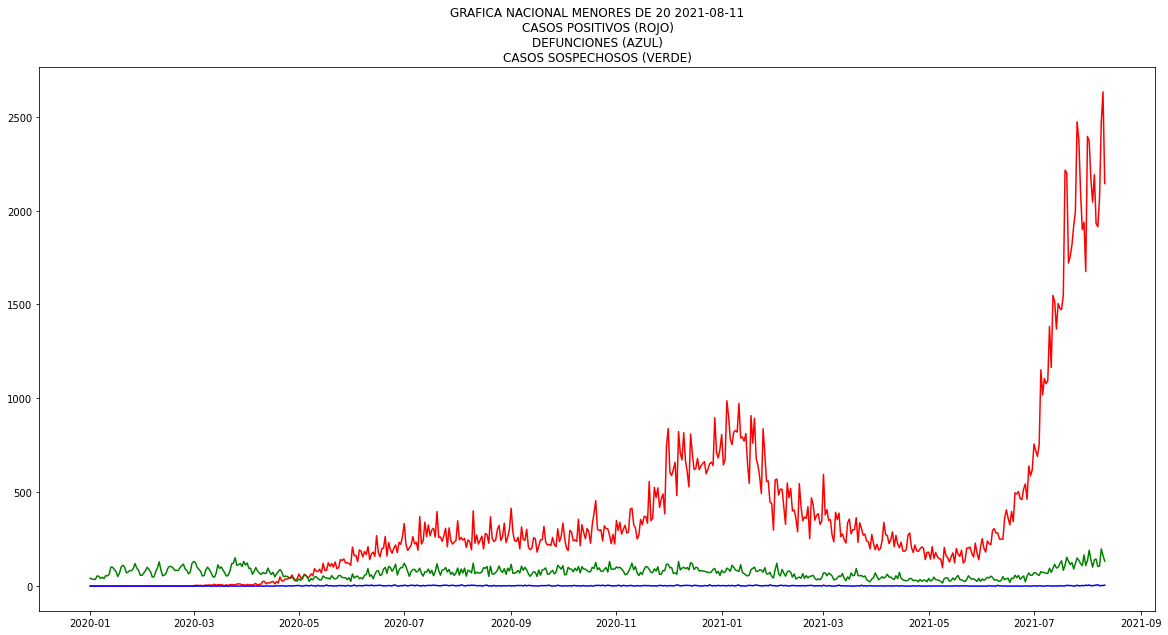

In [ ]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MENORES DE 20 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [ ]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [ ]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [ ]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [ ]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

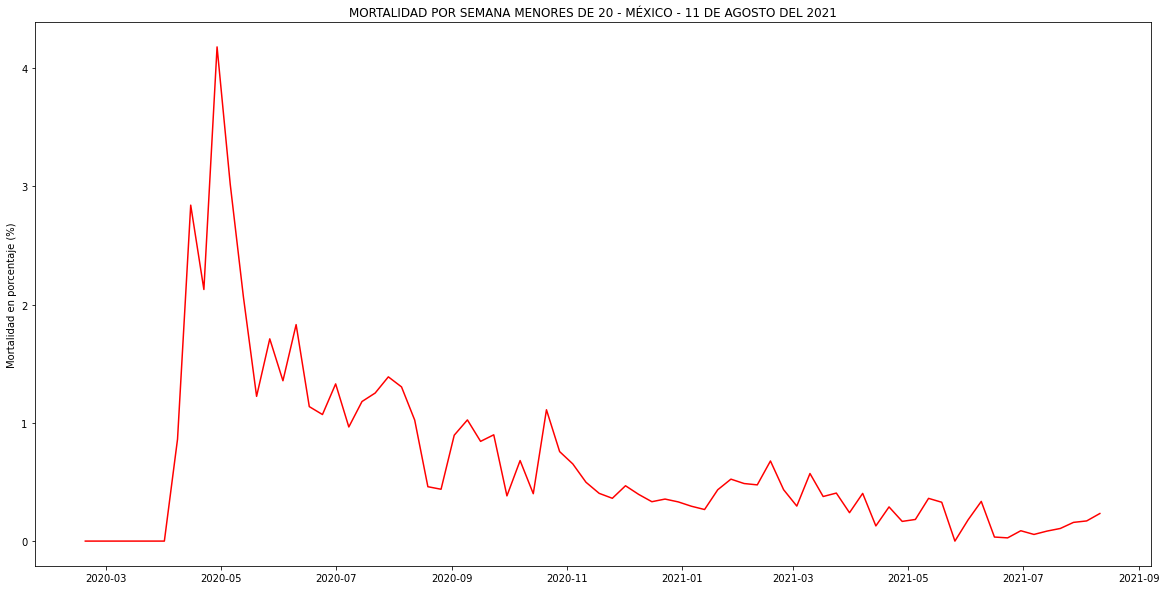

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MENORES DE 20 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [ ]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

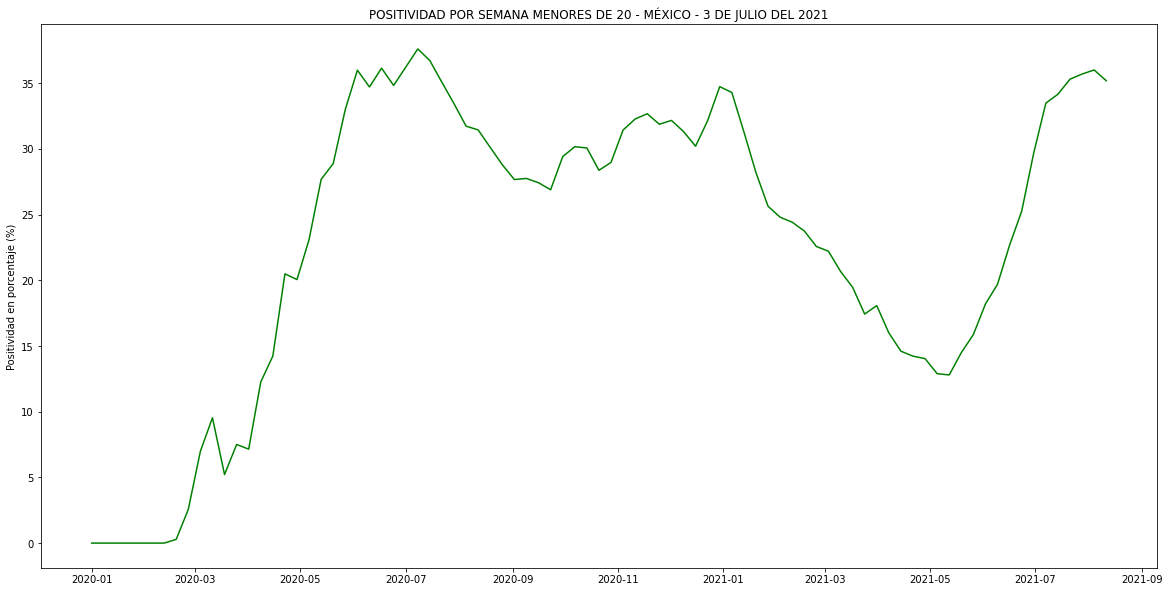

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MENORES DE 20 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

## Mortalidad en condiciones específicas
Se obtendrá la mortalidad y la incidancia de hospitalización y probabilidad de obtener enfermedad grave para algunos casos específicos.

### Caso Específico 1:

* SEXO_: HOMBRE
* EDAD: 21
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [ ]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [ ]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 21)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 28691
Porcentaje de Hospitalizados: 1.492%
Porcentaje de enfermos graves: 1.624%
Mortalidad: 0.188%


### Caso Específico 2:

* SEXO_: HOMBRE
* EDAD: 33
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [ ]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [ ]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 33)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 36871
Porcentaje de Hospitalizados: 4.657%
Porcentaje de enfermos graves: 4.044%
Mortalidad: 0.909%


### Caso Específico 3:

* SEXO_: HOMBRE
* EDAD: 35
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [ ]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [ ]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 35)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 35480
Porcentaje de Hospitalizados: 5.55%
Porcentaje de enfermos graves: 4.682%
Mortalidad: 1.195%


### Caso Específico 4:

* SEXO_: MUJER
* EDAD: 34
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [ ]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [ ]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "MUJER")
                           & (data_filtered["EDAD"] == 34)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 39890
Porcentaje de Hospitalizados: 3.199%
Porcentaje de enfermos graves: 2.838%
Mortalidad: 0.459%
